# Embedding space analysis

The goal here is to analyze the embedding space of trained models. 

We will visualize the embeddings of the words in the vocabulary, and also the embedding of the titles.

I hope that using UMAP, we can see some interesting clusters in the embedding space.

Also, thanks to cosine similarity, we will create a recommendation system based on the embeddings.

In [10]:

import torch
from classifier.article_dataset import ArticleDataset
from torch.utils.data import DataLoader
from classifier.models.mlp_classifier import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [11]:
# load a trained model 
def load_checkpoint(checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    hyperparams = checkpoint['hyperparameters']
    
    model = MLPClassifier(
        hyperparams['vocab_size'],
        hyperparams['embedding_dim'],
        hyperparams['hidden_dim'],
        hyperparams['num_classes'],
        hyperparams['num_hidden_layers']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  # evaluation mode
    return model, hyperparams


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = "../classifier/experiments/mlp/mlp.pth"

model, hyperparams = load_checkpoint(checkpoint_path, device)
dataset = ArticleDataset("../classifier/data/articles.csv")
filters = {
    "min_papers" : 5000, 
    "min_freq": 2,
}
dataset.apply_filters(filters)

In [12]:
print(hyperparams)
print(len(model))

{'vocab_size': 58648, 'embedding_dim': 300, 'hidden_dim': 128, 'num_classes': 19, 'num_hidden_layers': 3, 'dropout': 0.5, 'freeze_embeddings': False}
17668403


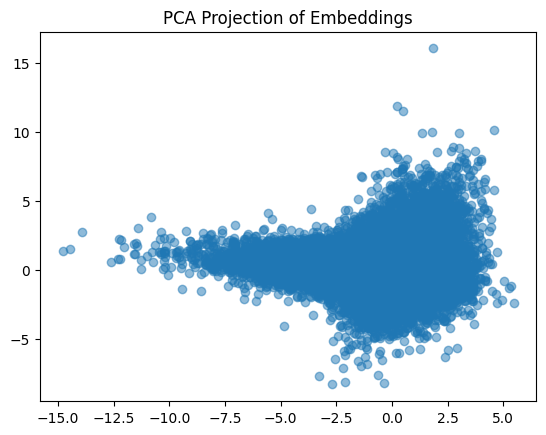

In [13]:
# Let's first perform a PCA before ressorting to better visualizations

emb = model.embedding.weight.detach()
pca = PCA(n_components=2)
reduced_emb = pca.fit_transform(emb.cpu().numpy())

plt.scatter(reduced_emb[:, 0], reduced_emb[:, 1], alpha=0.5)
plt.title("PCA Projection of Embeddings")
plt.show()

In [14]:
def get_word_from_coordonates(coordonates, points):
    distances = ((points - coordonates)**2).sum(axis=1)**0.5
    closest_idx = distances.argmin()
    return dataset.index_to_word[closest_idx]

coordonates = [-15,-15]
word = get_word_from_coordonates(coordonates, reduced_emb)
print(f"closest point to {coordonates} is {word}")

closest point to [-15, -15] is narrating


In [15]:
# Vertical 
x = np.linspace(0, 0, 20)
y = np.linspace(-10, 15, 20)

for x,y in zip(x,y):
    coord = [x,y]
    word = get_word_from_coordonates(coord, reduced_emb)
    print(f"closest point to {x.item(),y.item()} is {word}")

closest point to (0.0, -10.0) is ultracompact
closest point to (0.0, -8.68421052631579) is ultracompact
closest point to (0.0, -7.368421052631579) is n2edm
closest point to (0.0, -6.052631578947368) is defied
closest point to (0.0, -4.7368421052631575) is korn
closest point to (0.0, -3.421052631578947) is detuning
closest point to (0.0, -2.1052631578947363) is believable
closest point to (0.0, -0.7894736842105257) is semiconvexity
closest point to (0.0, 0.526315789473685) is sungrazing
closest point to (0.0, 1.8421052631578956) is tarsi
closest point to (0.0, 3.157894736842106) is 100nm
closest point to (0.0, 4.473684210526317) is 3783
closest point to (0.0, 5.789473684210527) is krause
closest point to (0.0, 7.10526315789474) is hyperpolarizability
closest point to (0.0, 8.421052631578949) is pp
closest point to (0.0, 9.736842105263158) is voigt
closest point to (0.0, 11.05263157894737) is xas
closest point to (0.0, 12.368421052631582) is ruo
closest point to (0.0, 13.684210526315791)

On n'a pas l'impression qu'il y ai de logique dans la proximité des mots.

On va essayer de les traverser horizontallement. 

In [16]:
# horizontal 
x = np.linspace(-15, 5, 20)
y = np.linspace(1, 1, 20)

for x,y in zip(x,y):
    coord = [x,y]
    word = get_word_from_coordonates(coord, reduced_emb)
    print(f"closest point to {x.item(),y.item()} is {word}")

closest point to (-15.0, 1.0) is cherkis
closest point to (-13.947368421052632, 1.0) is jucys
closest point to (-12.894736842105264, 1.0) is physisorbed
closest point to (-11.842105263157894, 1.0) is cerf
closest point to (-10.789473684210527, 1.0) is comonad
closest point to (-9.736842105263158, 1.0) is jordanian
closest point to (-8.68421052631579, 1.0) is symmetrised
closest point to (-7.631578947368421, 1.0) is loxodromic
closest point to (-6.578947368421053, 1.0) is lithosphere
closest point to (-5.526315789473685, 1.0) is skeletally
closest point to (-4.473684210526317, 1.0) is manoeuvres
closest point to (-3.4210526315789487, 1.0) is cads
closest point to (-2.3684210526315788, 1.0) is muram
closest point to (-1.3157894736842106, 1.0) is sdh
closest point to (-0.2631578947368425, 1.0) is multiflows
closest point to (0.7894736842105257, 1.0) is advancing
closest point to (1.8421052631578938, 1.0) is 1700
closest point to (2.8947368421052637, 1.0) is rossi
closest point to (3.94736

On ne gagne pas beaucoup d'information avec l'acp passons à umap. 

In [17]:

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=-1)
umap_emb = reducer.fit_transform(emb.cpu().numpy())

c:\Users\cheri\nsi\M1\Arxiv-ML\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


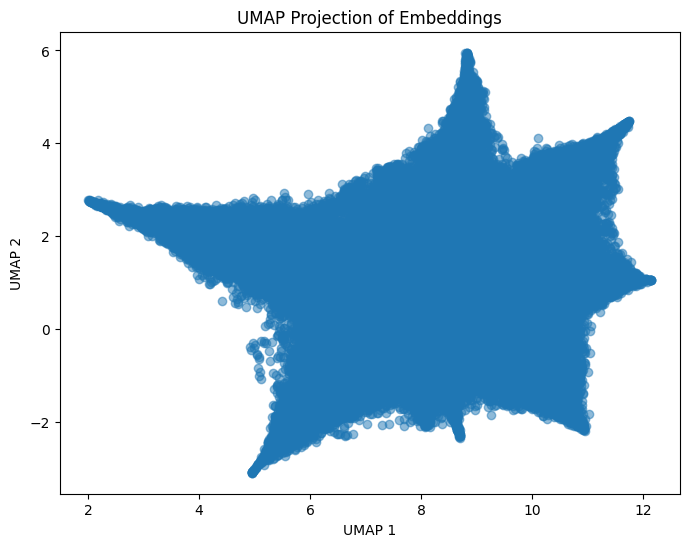

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], alpha=0.5)
plt.title("UMAP Projection of Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [19]:
def get_k_nearest_words(coord, points, k):
    coord = np.array(coord)
    distances = np.linalg.norm(points - coord, axis=1)
    nearest_indices = np.argsort(distances)[:k]
    return [dataset.index_to_word[idx] for idx in nearest_indices]

coord = [5,-3] #
print(f"closest point to {coord} is {get_word_from_coordonates(coord, umap_emb)}")
words = get_k_nearest_words(coord, umap_emb, 20)
words

closest point to [5, -3] is subarrays


['subarrays',
 'boot',
 'intrusion',
 'pruw',
 'hyperexponential',
 '415',
 'preparata',
 'arnol',
 'msun',
 'clones',
 'ndcg',
 'spyglass',
 'ultracompact',
 'macwilliams',
 'transrectal',
 'narrating',
 'terascale',
 'multiserver',
 'n2edm',
 'flr']

On dirait bien que la notion de proximité est respectée.

On va donc faire du clustering sur cet espace. 

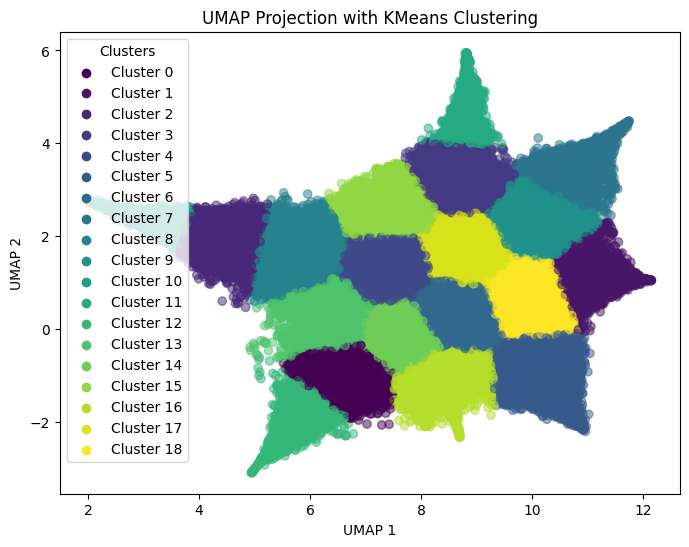

In [20]:

n_clusters = 19

# Perform KMeans clustering on the UMAP embeddings
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(umap_emb)

plt.figure(figsize=(8, 6))
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title("UMAP Projection with KMeans Clustering")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
unique_clusters = np.unique(clusters)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
for i, uc in enumerate(unique_clusters):
    plt.scatter([], [], color=colors[i], label=f"Cluster {uc}")
plt.legend(title="Clusters")
plt.show()

In [21]:

for cl in unique_clusters:
    cluster_indices = np.where(clusters == cl)[0] # returns the indices (from clusters) that correspond to the current cluster
    words = [dataset.index_to_word[idx] for idx in cluster_indices[:20]]
    print(f"Cluster {cl}: {', '.join(words)}")

Cluster 0: unveiling, memories, enhanced, compression, generalization, overfitting, integer, algorithms, me, multiplexing, accelerating, efficient, functionality, leveraging, world, task, identification, via, breaking, information
Cluster 1: vibrational, physics, mechanics, ultrasound, charged, photonic, backflow, chemistry, electronic, metamaterials, wavefunctions, fock, flow, unidirectional, electrons, warm, cooperation, physical, methane, electrostatic
Cluster 2: moduli, matrices, operator, estimates, combinatorial, slowly, stabilization, graphs, convex, unbounded, calculus, topology, decompositions, numbers, maximal, infinite, singular, asymptotics, sharp, asymptotically
Cluster 3: <unk>, away, monte, chiral, mirror, array, multifield, sign, close, sun, separate, site, ground, relax, squared, simulated, mapping, z, kovacs, camera
Cluster 4: in, the, after, by, les, high, system, correspondence, at, to, systems, u, zipping, ab, higher, varying, behavior, space, dependent, signature


Les clusters correspondent à des thèmes, c'est bien ce qu'on espérait.

Par exemple, le cluster 18 donne:  adam, contextual, semantic, transformer, interpretability, decoders, processor, training, algorithmic
Ce qui correspond au machine learning. 

Et le 10 donne : energies, vibrational, physics, mechanics, ultrasound, charged, photonic, backflow, chemistry, metamaterials
Ce qui correspond à la physique.

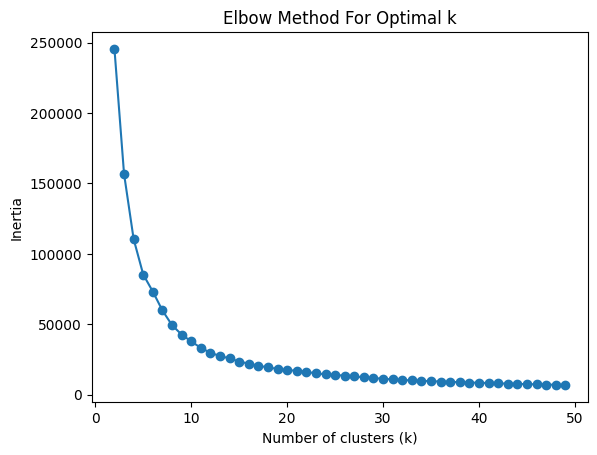

In [22]:
inertia = []
k_range = range(2, 50)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(umap_emb)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

### Now it's getting really interesting

UMAP preserves local structure, so we can see the clusters of words that are similar to each other.

For instance, "quantum, energies, many, body, particle" are all in the same cluster and same for "adam, semantic, overfitting, transformer, decoders, algorithms, scalable, training". 

we can confortably say that our classifier learned a coherent representation of the words in the embedding space and UMAP is a great tool to visualize it.

### Let's do the same for the titles

In [23]:
# a title is a sequence of words 
# the sequence is averaged along the temporal axis to create an embedding of the same size as a word
# i.e pooling avg 

# let's embed the titles 
# first we need to retrieve them using the dataloader 
from torch.nn.utils.rnn import pad_sequence

def custom_collate(batch, pad_value=0):
    sequences, labels = zip(*batch)
    # Padding sequences to obtain tensors of uniform size
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=pad_value)
    labels = torch.tensor(labels)
    return padded_sequences, labels

dataloader = DataLoader(dataset, batch_size=64, collate_fn=custom_collate, shuffle=False)

# useless but wanted to remind myself how do dataloaders work
for batch, (padded_sequences, labels) in enumerate(dataloader): 
    for t, (seq, label) in enumerate(zip(padded_sequences, labels)):
        title = [dataset.index_to_word[seq[i].item()] for i in range(len(seq)) if seq[i].item() != 0]
        cat = dataset.index_to_class[label.item()]
        print(title, cat)
    break

['coexistence', 'of', 'distinct', 'mobility', 'edges', 'in', 'a', '1d', 'quasiperiodic', 'mosaic', 'model'] cond-mat
['beyond', 'disorder', 'unveiling', 'cooperativeness', 'in', 'multidirectional', 'associative', 'memories'] cond-mat
['on', 'the', 'nature', 'of', 'the', 'glass', 'transition', 'in', 'metallic', 'glasses', 'after', 'deep', 'relaxation'] cond-mat
['relationship', 'between', 'the', 'shear', 'moduli', 'and', 'defect', 'induced', 'structural', 'relaxation', 'entropy', 'metallic', 'glasses'] cond-mat
['machine', 'learning', 'enhanced', 'calculation', 'of', 'quantum', 'classical', 'binding', 'free', 'energies'] physics
['hierarchical', 'quantum', 'embedding', 'by', 'machine', 'learning', 'for', 'large', 'molecular', 'assemblies'] physics
['many', 'body', 'localization', 'and', 'particle', 'statistics', 'in', 'disordered', 'bose', 'hubbard', 'model'] cond-mat
['interaction', 'correlated', 'random', 'matrices'] cond-mat
['critical', 'dynamics', 'in', 'short', 'range', 'quadratic

In [24]:
# we now use the dataloader to embed the titles using batches (bc the dataset is way too big)
def embed_all_titles_in_batches():
    model.eval()
    all_emb = []

    with torch.no_grad():
        for padded_sequences, _ in dataloader:
            # we use the forward code 
            emb = model.embedding(padded_sequences)  # [total_titles, seq_len, embedding_dim]
            mask = (padded_sequences != 0).unsqueeze(-1).float()
            emb = emb * mask
            sum_emb = emb.sum(dim=1)
            lengths = mask.sum(dim=1)
            avg_emb = sum_emb / lengths.clamp(min=1)  # [total_titles, embedding_dim]
            all_emb.append(avg_emb.cpu())

    return torch.cat(all_emb, dim=0)

emb_titles = embed_all_titles_in_batches()

In [25]:
emb_titles.shape # [total_titles, emb_dim]

torch.Size([1228329, 300])

In [ ]:
# now that we have our embedded titles, we can reproduce what we did for the words 

# let's skip the PCA and directly plot the UMAP 
reducer_titles = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=-1)
umap_emb_titles = reducer_titles.fit_transform(emb_titles.cpu().numpy())

c:\Users\cheri\nsi\M1\Arxiv-ML\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# as it takes approximatly 45min to perform the UMAP, we save it in a csv file
df = pd.DataFrame(umap_emb)
df.to_csv("embedding_umap.csv", index=False)

In [ ]:
umap = pd.read_csv('embedding_umap.csv')

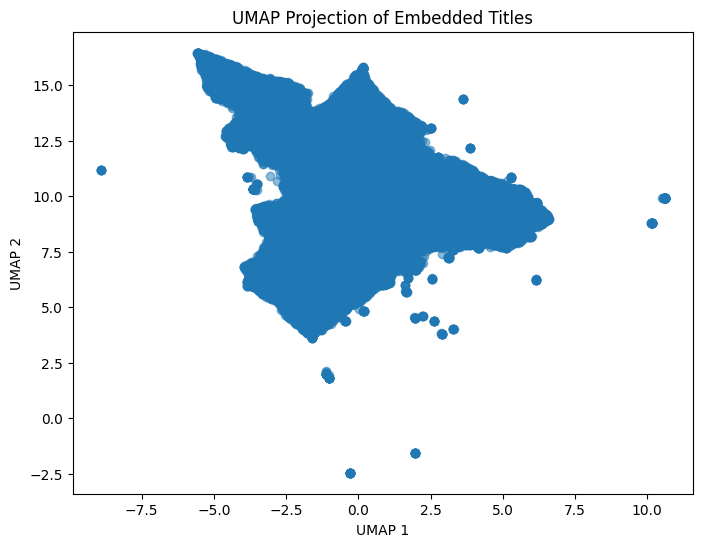

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(umap["0"], umap["1"], alpha=0.5)
plt.title("UMAP Projection of Embedded Titles")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [ ]:
n_clusters = 19
kmeans_titles = KMeans(n_clusters=n_clusters, random_state=42)

In [ ]:
clusters_titles = kmeans_titles.fit_predict(umap)

c:\Users\cheri\nsi\M1\Arxiv-ML\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


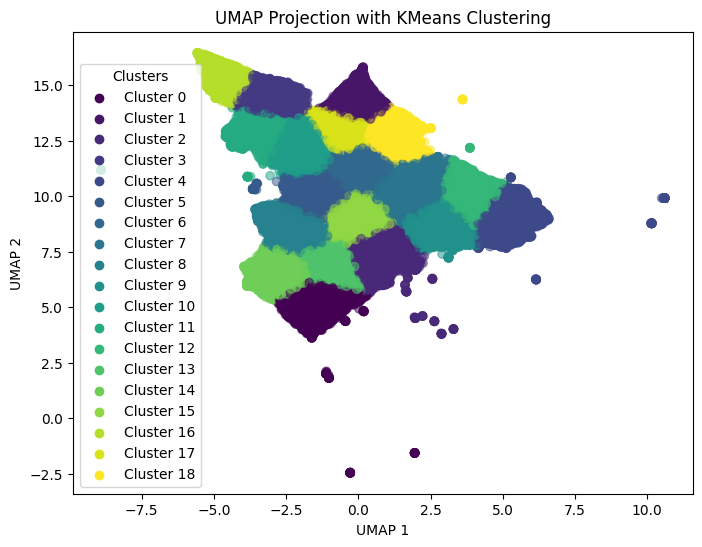

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(umap["0"], umap["1"], c=clusters_titles, cmap='viridis', alpha=0.5)
plt.title("UMAP Projection with KMeans Clustering")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
unique_clusters = np.unique(clusters_titles)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
for i, uc in enumerate(unique_clusters):
    plt.scatter([], [], color=colors[i], label=f"Cluster {uc}")
plt.legend(title="Clusters")
plt.show()

In [ ]:
# We can retrieve an embedded title from it's position in umap or emb_titles
# Indeed, the dataloader is intialized with shuffle = False, so each index in emb_titles corresponds to the index in dataset.data
# Let's test this
idxs = dataset.data.index
idx = np.random.choice(idxs)
t_str = dataset.data.iloc[idx].title
t_seq = dataset[idx]
print(f"The title is : {t_str}")
print(f"it's tokenize representation is {t_seq}")

# Now, we must check if the embedded title at this location is the same
emb = model.embedding(t_seq[0])  
sum_emb = emb.sum(dim=0)     
lengths = len(t_seq[0])   
avg_emb = sum_emb / lengths
avg_emb
dists = torch.norm(emb_titles - avg_emb, dim=1)
min_index = torch.argmin(dists)
print(f"closest index in emb_titles {min_index.item()} index in the dataset {idx}")
print(f'the distance is {torch.min(dists)}')
# It works !!
# dist is 0 i.e they are equal


The title is : Language-Guided Visual Perception Disentanglement for Image Quality
  Assessment and Conditional Image Generation
it's tokenize representation is (tensor([1513, 2301,  150, 2758, 4606,   50, 2212, 2759, 1954,   33,  457, 2212,
        3360]), tensor(4))
closest index in emb_titles 981573 index in the dataset 981573
the distance is 0.0


In [ ]:
for cl in unique_clusters:
    cluster_indices = np.where(clusters_titles == cl)[0] # returns the indices (from clusters) that correspond to the current cluster
    titles = [dataset.data.iloc[idx].title.replace("\n", "") for idx in cluster_indices[:10]]
    print(f"Cluster {cl}:")
    for t in titles:
        print(t)

Cluster 0:
Efficient optimization of neural network backflow for ab-initio quantum  chemistry
Deep learning-based holography for T-linear resistivity
Isolating the hard core of phaseless inference: the Phase selection  formulation
Thermal transport of amorphous hafnia across the glass transition
Optimal generalisation and learning transition in extensive-width  shallow neural networks near interpolation
Beyond traditional box-covering: Determining the fractal dimension of  complex networks using a fixed number of boxes of flexible diameter
Measurement-induced Lévy flights of quantum information
Revealing the role played by $α$- and $β$-relaxation in  hydrostatically compressed metallic glasses
Role of Random Interaction Connection in the Order Transition of Active  Matter Based on the Vicsek Model
Aging of colloidal gels in microgravity
Cluster 1:
When Can You Get Away with Low Memory Adam?
Bulk-edge correspondence at the spin-to-integer quantum Hall effect  crossover in topological su

In [ ]:
from collections import Counter

for cl in unique_clusters:
    cluster_indices = np.where(clusters_titles == cl)[0]
    cats = [dataset.itoc[dataset[i][1].item()] for i in cluster_indices]
    count = Counter(cats)
    print(f"Cluster {cl}:")
    for cat, num in count.items():
        print(f"  {cat}: {num}")
    

Cluster 0:
  physics: 12339
  hep-th: 1068
  cond-mat: 9726
  stat: 3265
  quant-ph: 2197
  gr-qc: 1018
  cs: 26776
  q-bio: 2491
  math: 26276
  nlin: 1595
  math-ph: 973
  nucl-th: 741
  q-fin: 998
  eess: 2963
  hep-ph: 1408
  astro-ph: 6896
  econ: 740
  hep-ex: 480
  nucl-ex: 673
Cluster 1:
  cs: 15507
  cond-mat: 5660
  quant-ph: 1254
  q-fin: 555
  stat: 1885
  math: 15376
  physics: 7240
  nlin: 896
  q-bio: 1500
  hep-th: 598
  astro-ph: 3901
  math-ph: 565
  eess: 1719
  hep-ph: 770
  nucl-th: 446
  gr-qc: 631
  hep-ex: 276
  econ: 438
  nucl-ex: 369
Cluster 2:
  physics: 4999
  cond-mat: 3992
  quant-ph: 912
  q-bio: 1018
  cs: 11049
  stat: 1335
  math: 10769
  nlin: 665
  math-ph: 413
  astro-ph: 2738
  hep-th: 425
  eess: 1236
  hep-ph: 583
  gr-qc: 405
  nucl-th: 336
  hep-ex: 203
  nucl-ex: 278
  q-fin: 369
  econ: 304
Cluster 3:
  quant-ph: 748
  math: 8548
  cs: 9063
  cond-mat: 3222
  q-bio: 828
  physics: 4027
  stat: 1075
  hep-th: 318
  eess: 921
  nlin: 505
  mat

KeyboardInterrupt: 

In [ ]:
print(count.keys())

dict_keys(['cond-mat', 'q-bio', 'cs', 'quant-ph', 'physics', 'math', 'nlin', 'stat', 'hep-th', 'nucl-th', 'math-ph', 'eess', 'q-fin', 'hep-ph', 'astro-ph', 'gr-qc', 'econ', 'nucl-ex', 'hep-ex'])
